# Configure notebook

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

train = pd.read_csv('C:/Users/Theod/Desktop/Grad_School/W207_ML/github_assignments/W207-final-project/Data/train.csv')
test = pd.read_csv('C:/Users/Theod/Desktop/Grad_School/W207_ML/github_assignments/W207-final-project/Data/test.csv')

quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

# missing values

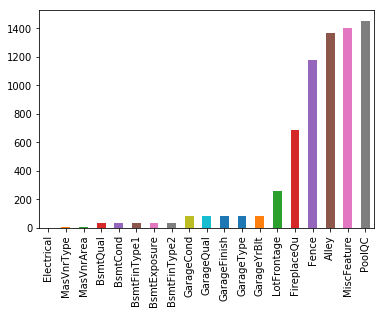

In [7]:
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

# not normal

C:\Users\Theod\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


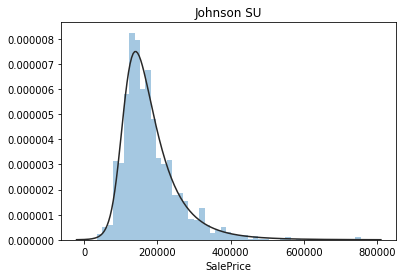

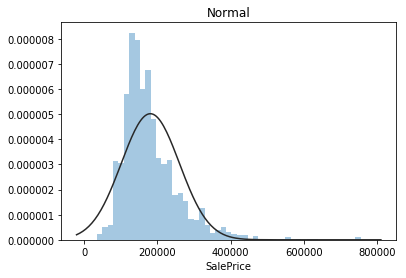

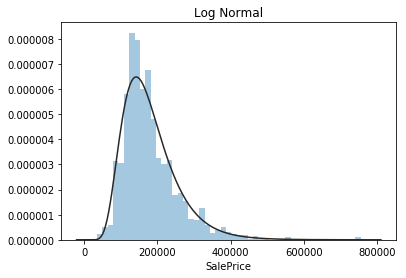

In [8]:
import scipy.stats as st
y = train['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

# Transforming into normal distibution

In [9]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


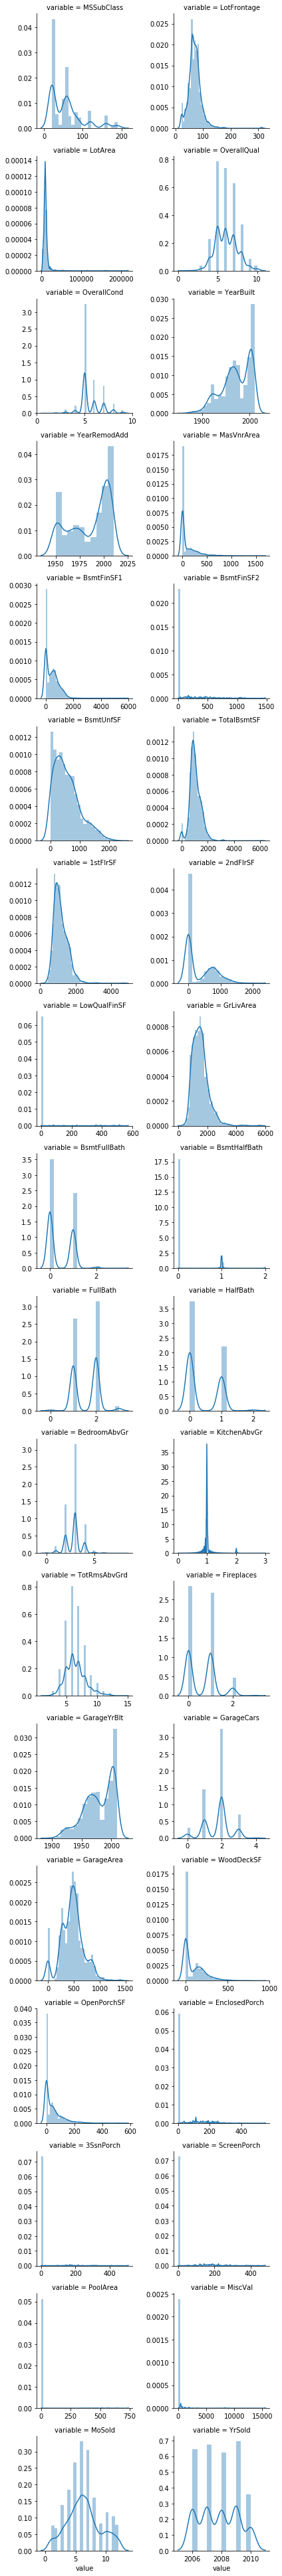

In [10]:
f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

# Categorical Variables
With qualitative variables we can implement two methods. First one is to check distribution of SalePrice with respect to variable values and enumerate them. Second to create dummy variable for each possible category.

In [ ]:
for c in qualitative:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")

# Checking variabilities

C:\Users\Theod\Anaconda3\lib\site-packages\scipy\stats\stats.py:2923: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / float(len(a))


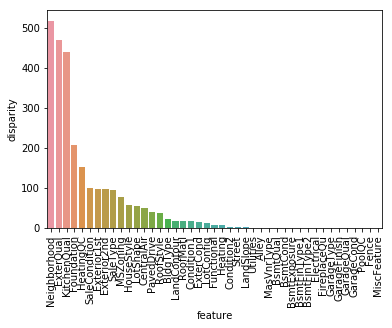

In [11]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(train)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

# Encoding qualitative features

In [1]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

NameError: name 'qualitative' is not defined

# Spearman Correlations

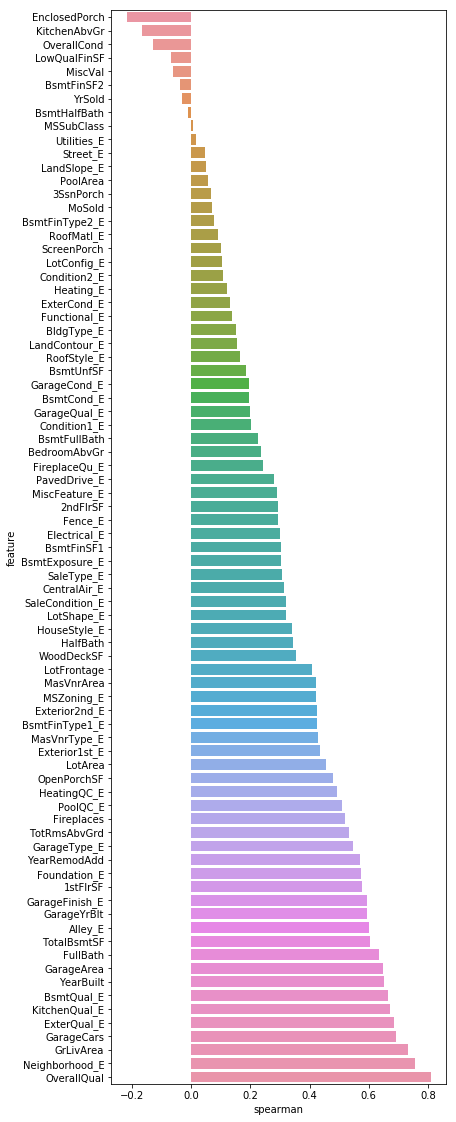

In [13]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qual_encoded
spearman(train, features)

# Heat maps

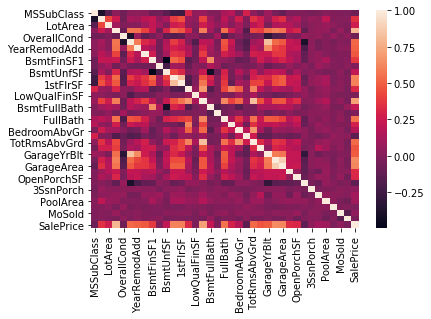

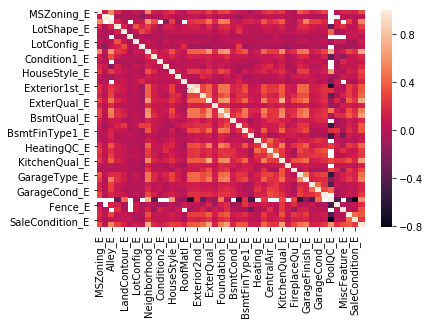

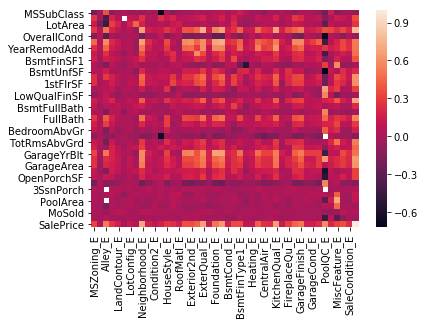

In [14]:
plt.figure(1)
corr = train[quantitative+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(2)
corr = train[qual_encoded+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['SalePrice'], columns=qual_encoded+['SalePrice'])
for q1 in quantitative+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        corr.loc[q1, q2] = train[q1].corr(train[q2])
sns.heatmap(corr)

# Pair plots 
Comparing sale price to each independing variable

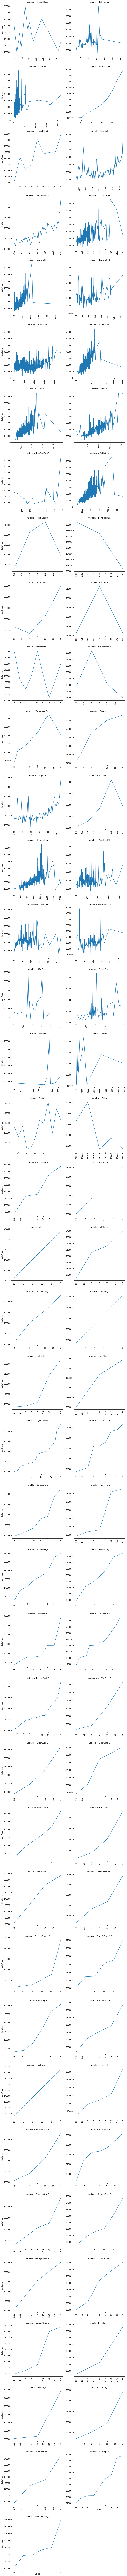

In [16]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f = pd.melt(train, id_vars=['SalePrice'], value_vars=quantitative+qual_encoded)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, height=5)
g = g.map(pairplot, "value", "SalePrice")

# Price Segments
It is possible that correlations shift with change of SalePrice.

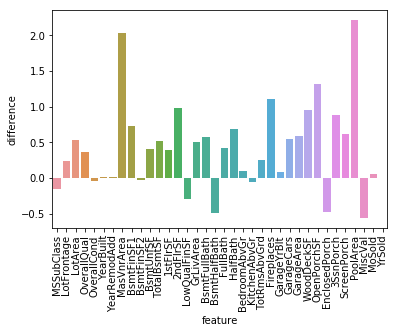

In [17]:
features = quantitative

standard = train[train['SalePrice'] < 200000]
pricey = train[train['SalePrice'] >= 200000]

diff = pd.DataFrame()
diff['feature'] = features
diff['difference'] = [(pricey[f].fillna(0.).mean() - standard[f].fillna(0.).mean())/(standard[f].fillna(0.).mean())
                      for f in features]

sns.barplot(data=diff, x='feature', y='difference')
x=plt.xticks(rotation=90)

# Clustering

0.7547225727772772


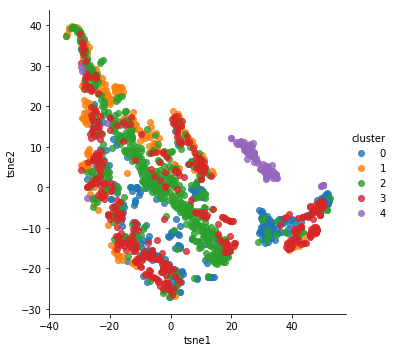

In [29]:
features = quantitative + qual_encoded
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = train[features].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

C:\Users\Theod\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


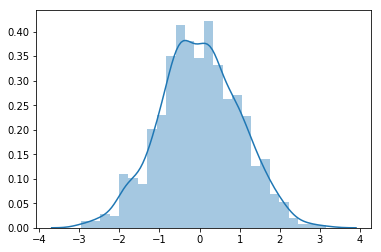

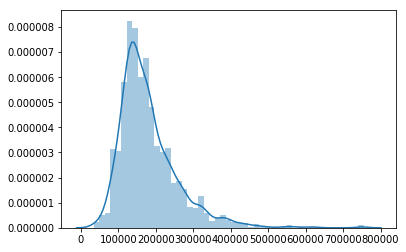

In [30]:
y = train['SalePrice'].values
def johnson(y):
    gamma, eta, epsilon, lbda = stats.johnsonsu.fit(y)
    yt = gamma + eta*np.arcsinh((y-epsilon)/lbda)
    return yt, gamma, eta, epsilon, lbda

def johnson_inverse(y, gamma, eta, epsilon, lbda):
    return lbda*np.sinh((y-gamma)/eta) + epsilon

yt, g, et, ep, l = johnson(y)
yt2 = johnson_inverse(yt, g, et, ep, l)
plt.figure(1)
sns.distplot(yt)
plt.figure(2)
sns.distplot(yt2)

# Regression

In [46]:
def error(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

def log_transform(feature):
    train[feature] = np.log1p(train[feature].values)

def quadratic(feature):
    train[feature+'2'] = train[feature]**2
    
log_transform('GrLivArea')
log_transform('1stFlrSF')
log_transform('2ndFlrSF')
log_transform('TotalBsmtSF')
log_transform('LotArea')
log_transform('LotFrontage')
log_transform('KitchenAbvGr')
log_transform('GarageArea')

quadratic('OverallQual')
quadratic('YearBuilt')
quadratic('YearRemodAdd')
quadratic('TotalBsmtSF')
quadratic('2ndFlrSF')
quadratic('Neighborhood_E')
quadratic('RoofMatl_E')
quadratic('GrLivArea')

qdr = ['OverallQual2', 'YearBuilt2', 'YearRemodAdd2', 'TotalBsmtSF2',
        '2ndFlrSF2', 'Neighborhood_E2', 'RoofMatl_E2', 'GrLivArea2']

train['HasBasement'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasGarage'] = train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train['Has2ndFloor'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasMasVnr'] = train['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
train['HasWoodDeck'] = train['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPorch'] = train['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPool'] = train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train['IsNew'] = train['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)

boolean = ['HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
            'HasPorch', 'HasPool', 'IsNew']


features = quantitative + qual_encoded + boolean + qdr
lasso = linear_model.LassoLarsCV(max_iter=10000)
X = train[features].fillna(0.).values
Y = train['SalePrice'].values
lasso.fit(X, np.log(Y))

Ypred = np.exp(lasso.predict(X))
error(Y, Ypred)

C:\Users\Theod\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.11984835024236816

# testing Decision Trees

In [52]:
mini_train_data, mini_train_labels = X[:1000], Y[:1000]
test_data, test_labels = X[1000:], Y[1000:]

In [53]:
# import the regressor 
from sklearn.tree import DecisionTreeRegressor  
# create a regressor object 
regressor = DecisionTreeRegressor(random_state = 0)  
  
# fit the regressor with X and Y data 
regressor.fit(mini_train_data, mini_train_labels) 

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [54]:
regressor.score(mini_train_data, mini_train_labels)

1.0

In [56]:
pred_labels = regressor.predict(test_data)

In [59]:
from sklearn import metrics
metrics.accuracy_score(pred_labels, test_labels)

0.006521739130434782

# testing logistic regression

In [60]:
from sklearn.linear_model import LogisticRegression

In [66]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X, y)

C:\Users\Theod\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [67]:
clf.score(X, y)

0.013013698630136987